In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.inference_early_stop import InferenceEarlyStop
from lib.nyt_connections import get_connections_games, get_connections_tasks
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.temporal_clue import get_temporal_clue_tasks
from lib.tokenize import TaskResultTokenizer
from lib.tune import (
    clear_iteration_dirs,
    get_iteration,
    get_last_iteration_dir,
    last_tune_log,
    tune,
    Verbosity,
)
from lib.utils import symlink_shm, rsync_dir
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "042"
run = wandb.init(
    project="rl-experiments",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "nyt-connections"},
)

games = get_connections_games()
tasks = list(
    islice(get_connections_tasks(games, parse_answers_liberally=False), len(games) * 2)
)
val_tasks = tasks[436:508]
test_tasks = tasks[508 : len(games)]
train_tasks = tasks[len(games) : len(games) + 436]
random.seed(42)
random.shuffle(train_tasks)
len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(72, 92, 436)

In [6]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0
wandb.config["tanh"] = tanh = True

expected_tokens = 1000  # Expected completion tokens per task sample
inference_early_stop = InferenceEarlyStop(alpha=0.992, threshold=-3.0)
wandb.config["lr"] = lr = 2e-6
wandb.config["betas"] = betas = (0.9, 0.99)
wandb.config["weight_decay"] = weight_decay = 0.1
model = models.qwen_14b()
wandb.config["model"] = model.base_model
num_iterations = 1_000
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 50
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 16
wandb.config["tasks_per_iter"] = tasks_per_iter = 32
sync_dir = output_dir  # symlink_shm(output_dir) or output_dir
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

$ vllm serve Qwen/Qwen2.5-14B-Instruct --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --port=8000 --api-key=default
INFO 02-24 21:11:55 __init__.py:190] Automatically detected platform cuda.
INFO 02-24 21:11:56 api_server.py:840] vLLM API server version 0.7.2
INFO 02-24 21:11:56 api_server.py:841] args: Namespace(subparser='serve', model_tag='Qwen/Qwen2.5-14B-Instruct', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=None, ssl_cert_reqs=0, root_

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:03,  1.76it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.73it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:02,  1.71it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:01<00:01,  2.33it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  2.07it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:00,  2.01it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:03<00:00,  1.85it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.78it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.87it/s]



INFO 02-24 21:13:04 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=18212) INFO 02-24 21:13:04 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=18212) INFO 02-24 21:13:08 worker.py:267] Memory profiling takes 3.92 seconds
(VllmWorkerProcess pid=18212) INFO 02-24 21:13:08 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=18212) INFO 02-24 21:13:08 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-24 21:13:08 worker.py:267] Memory profiling takes 3.97 seconds
INFO 02-24 21:13:08 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-24 21:13:08 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [17908]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-24 21:13:56 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:56778 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/144 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [00:27<00:00, 131.26it/s, completion_tokens=43, prompt_tokens=166, reward=0.0295, token_logprobs=68127]


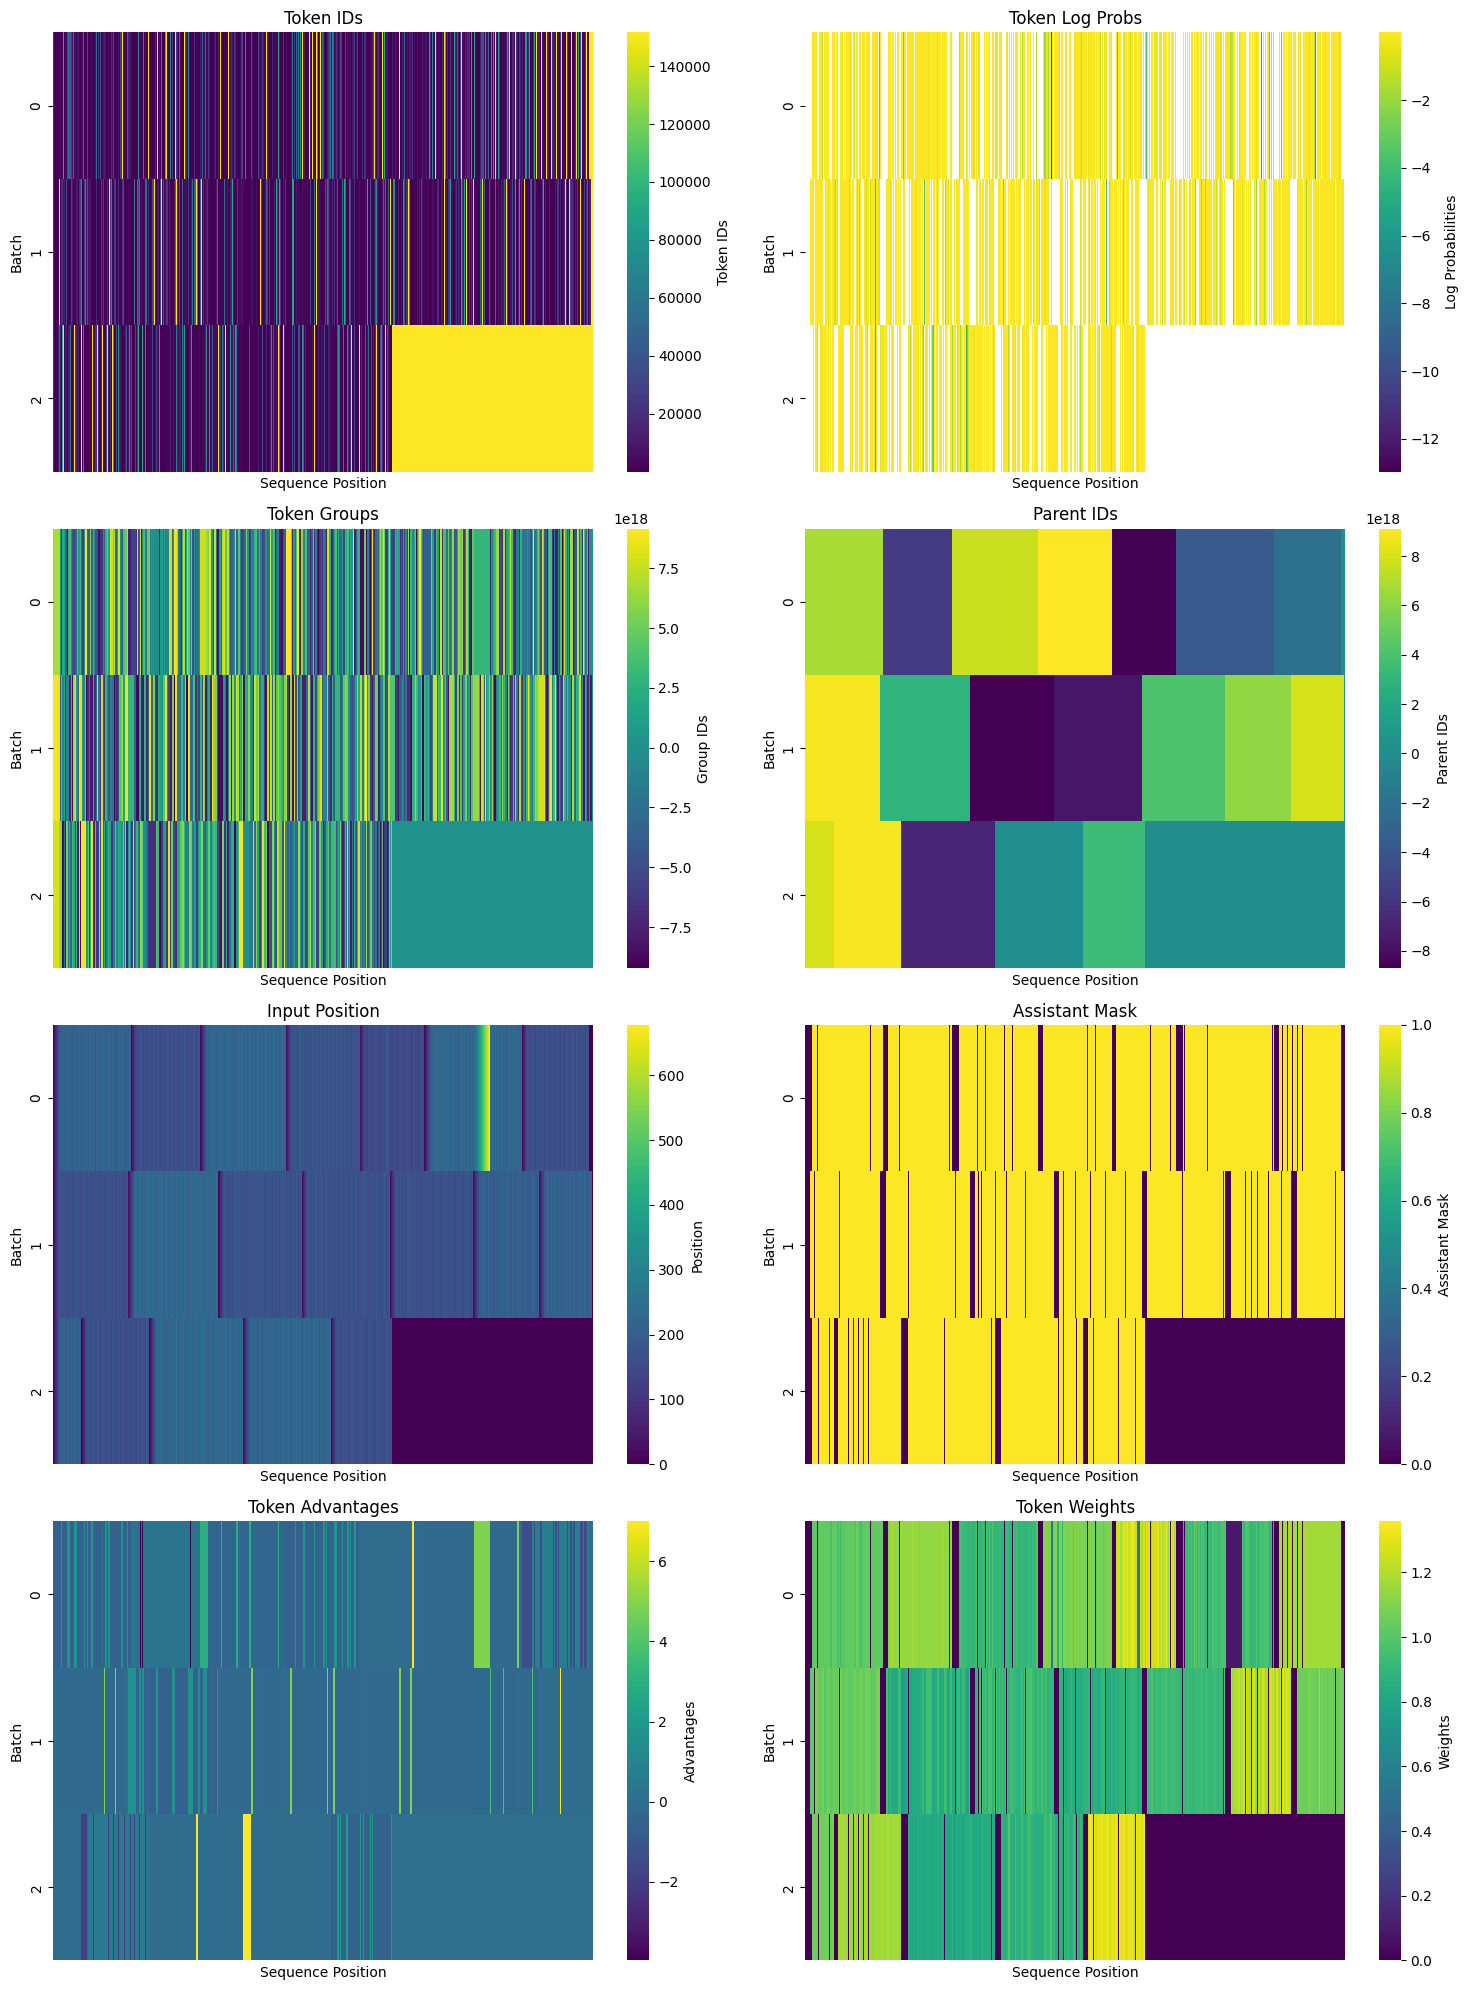

Download complete. Moving file to /home/gcpuser/.cache/huggingface/hub/models--Qwen--Qwen2.5-14B-Instruct/blobs/a6344aac8c09253b3b630fb776ae94478aa0275b
Download complete. Moving file to /home/gcpuser/.cache/huggingface/hub/models--Qwen--Qwen2.5-14B-Instruct/blobs/6634c8cc3133b3848ec74b9f275acaaa1ea618ab
Download complete. Moving file to /home/gcpuser/.cache/huggingface/hub/models--Qwen--Qwen2.5-14B-Instruct/blobs/cdb53558f3d3871db6823dd95ecac029044757a0
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/042/config.yaml
Running with torchrun...


W0224 21:14:45.218000 20062 torch/distributed/run.py:793] 
W0224 21:14:45.218000 20062 torch/distributed/run.py:793] *****************************************
W0224 21:14:45.218000 20062 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0224 21:14:45.218000 20062 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--Qwen--Qwen2.5-14B-Instruct/snapshots/cf98f3b3bbb457ad9e2bb7baf9a

Writing logs to models/042/logs/log_1740431690.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.74 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|1|Loss: -0.0013: 100%|██████████| 1/1 [01:00<00:00, 60.36s/it, entropy=0.168, kl_div=nan, loss=-0.00126, policy=-0.00126]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
IN

rsyncing /home/gcpuser/sky_workdir/experiments/models/042 to gs://atreides/openpipe/models/042
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/042/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/042/0001 --port=8000 --api-key=default
INFO 02-24 21:17:22 __init__.py:190] Automatically detected platform cuda.
INFO 02-24 21:17:23 api_server.py:840] vLLM API server version 0.7.2
INFO 02-24 21:17:23 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/042/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=N

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:03,  1.88it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.64it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.59it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:02,  1.53it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:03<00:01,  1.53it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.52it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:04<00:00,  1.53it/s]


(VllmWorkerProcess pid=23191) INFO 02-24 21:17:44 model_runner.py:1115] Loading model weights took 13.9281 GB


Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.96it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.70it/s]



INFO 02-24 21:17:44 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=23191) INFO 02-24 21:17:47 worker.py:267] Memory profiling takes 2.38 seconds
(VllmWorkerProcess pid=23191) INFO 02-24 21:17:47 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=23191) INFO 02-24 21:17:47 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-24 21:17:47 worker.py:267] Memory profiling takes 2.49 seconds
INFO 02-24 21:17:47 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-24 21:17:47 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; PyTorch activation peak memory takes 5.70GiB; the rest of the memory reserved for KV Cache is 53.71GiB.
INFO 02-

In [ ]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=240 + 30 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            n=2,
            on_chunk=inference_early_stop,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            on_chunk=inference_early_stop,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    for metric in val_stats.total_metrics:
        wandb_data[metric] = val_stats.total_metrics[metric] / val_stats.grades
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
        # see ./logs/rsync.log for output
        asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/"))
    except Exception:
        pass
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=model.tune_num_output_chunks,
            compile=True,
        ),
        verbosity=verbosity,
    )
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/"))